# Import things

In [1]:
package_path = "../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master/"
import sys 
sys.path.append(package_path)

import os
import glob
import time
import random
import numpy as np
import pandas as pd

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils import data as torch_data
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import efficientnet_pytorch

from sklearn.model_selection import StratifiedKFold

In [2]:
patient_ids = sorted(os.listdir("/kaggle/input/rsna-miccai-png/train/"))
bad_ids = ['00109', '00123', '00709']
patient_ids = [i for i in patient_ids if i not in bad_ids]


Flair_files = []
T1w_files = []
T1wCE_files = []
T2w_files = []

for i in tqdm(range(len(patient_ids))):
      patient_path = os.path.join("/kaggle/input/rsna-miccai-png/train/", patient_ids[i])
      Flair_files.append(len(os.listdir(os.path.join(patient_path, "FLAIR"))))
      T1w_files.append(len(os.listdir(os.path.join(patient_path, "T1w"))))
      T1wCE_files.append(len(os.listdir(os.path.join(patient_path, "T1wCE"))))
      T2w_files.append(len(os.listdir(os.path.join(patient_path, "T2w"))))

data_prop = {
    "Patient ID": patient_ids,
    "Flair": Flair_files,
    "T1w": T1w_files,
    "T1wCE": T1wCE_files,
    "T2w": T2w_files
    # "labels": y
}

no_frame_df = pd.DataFrame(data_prop)
print(no_frame_df.shape)

100%|██████████| 582/582 [00:13<00:00, 41.66it/s]

(582, 5)


In [ ]:
no_frame_df['Flair'].values.min()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 123

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

class CFG:
    img_size = 256
    n_frames = 14
    
    cnn_features = 256
    lstm_hidden = 32
    
    n_fold = 5
    n_epochs = 20

# Model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.map = nn.Conv2d(in_channels=4, out_channels=3, kernel_size=1)
        self.net = efficientnet_pytorch.EfficientNet.from_name("efficientnet-b0")
        checkpoint = torch.load("../input/efficientnet-pytorch/efficientnet-b0-08094119.pth")
        self.net.load_state_dict(checkpoint)
        
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=CFG.cnn_features, bias=True)
    
    def forward(self, x):
        x = F.relu(self.map(x))
        out = self.net(x)
        return out

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cnn = CNN()
        self.rnn = nn.LSTM(CFG.cnn_features, CFG.lstm_hidden, 2, batch_first=True)
        self.fc = nn.Linear(CFG.lstm_hidden, 1, bias=True)

    def forward(self, x):
        # x shape: BxTxCxHxW
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        output, (hn, cn) = self.rnn(r_in)
        
        out = self.fc(hn[-1])
        return out

In [5]:
model = Model()
x = torch.zeros((5, 14, 4, 256, 256))
out = model(x)
print(out)

tensor([[0.1446],
        [0.1531],
        [0.1506],
        [0.1523],
        [0.1531]], grad_fn=<AddmmBackward>)


# Data Processing

In [6]:
def load_image(path):
    image = cv2.imread(path, 0)
    if image is None:
        return np.zeros((CFG.img_size, CFG.img_size))
    
    image = cv2.resize(image, (CFG.img_size, CFG.img_size)) / 255
    return image.astype('f')

def uniform_temporal_subsample(x, num_samples):
    '''
        Moddified from https://github.com/facebookresearch/pytorchvideo/blob/d7874f788bc00a7badfb4310a912f6e531ffd6d3/pytorchvideo/transforms/functional.py#L19
        Args:
            x: input list
            num_samples: The number of equispaced samples to be selected
        Returns:
            Output list     
    '''
    t = len(x)
    indices = torch.linspace(0, t - 1, num_samples)
    indices = torch.clamp(indices, 0, t - 1).long()
    return [i.item() for i in indices]

x = torch.zeros((14, 32))
print(uniform_temporal_subsample(x, 14))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [8]:
class DataRetriever(Dataset):
    def __init__(self, paths, targets, transform=None):
        self.paths = paths
        self.targets = targets
        self.transform = transform
          
    def __len__(self):
        return len(self.paths)
    
    def read_video(self, vid_paths):
        video = [load_image(path) for path in vid_paths]
        if self.transform:
            seed = random.randint(0,99999)
            for i in range(len(video)):
                random.seed(seed)
                video[i] = self.transform(image=video[i])["image"]
        
        video = [torch.tensor(frame, dtype=torch.float32) for frame in video]
        if len(video)==0:
            video = torch.zeros(CFG.n_frames, CFG.img_size, CFG.img_size)
        else:
            video = torch.stack(video) # T * H * W
#         video = torch.transpose(video, 0, 1) # C * T * H * W
        return video
    
    def __getitem__(self, index):
        _id = self.paths[index]
        patient_path = f"../input/rsna-miccai-png/train/{str(_id.item()).zfill(5)}/"
        channels = []
        for t in ["FLAIR", "T1w", "T1wCE", "T2w"]:
            t_paths = sorted(
                glob.glob(os.path.join(patient_path, t, "*")), 
                key=lambda x: int(x[:-4].split("-")[-1]),
            )
            num_samples = CFG.n_frames
            if len(t_paths) < num_samples:
                in_frames_path = t_paths
            else:
                sampled_ids = uniform_temporal_subsample(t_paths, num_samples)
                in_frames_path = [t_paths[i] for i in sampled_ids]

            channel = self.read_video(in_frames_path)
            if channel.shape[0] == 0:
                print("1 channel empty")
                channel = torch.zeros(num_samples, CFG.img_size, CFG.img_size)
            channels.append(channel)
            
        channels = torch.stack(channels).transpose(0,1)
        
        y = torch.tensor(self.targets[index], dtype=torch.float)
        return {"X": channels.float(), "y": y}

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(
                                    shift_limit=0.0625, 
                                    scale_limit=0.1, 
                                    rotate_limit=10, 
                                    p=0.5
                                ),
                                A.RandomBrightnessContrast(p=0.5),
                            ])
valid_transform = A.Compose([
                            ])

In [ ]:
# data = DataRetriever(
#         df["BraTS21ID"].values, 
#         df["MGMT_value"].values
#     )
# data[584]['y']

In [10]:
df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
str(int(df["BraTS21ID"].values[100])).zfill(5)
excluded_images = [109, 123, 709]
df = df[~df.BraTS21ID.isin(excluded_images)]
df.reset_index(drop=True, inplace=True)
print(df)

     BraTS21ID  MGMT_value
0            0           1
1            2           1
2            3           0
3            5           1
4            6           1
..         ...         ...
577       1005           1
578       1007           1
579       1008           1
580       1009           0
581       1010           0

[582 rows x 2 columns]


In [ ]:
# train_data = TrainDataRetriever(
#     train_df["BraTS21ID"].values, 
#     train_df["MGMT_value"].values)
# for idx, dat in enumerate(train_data):
#     print('{} {} {}'.format(idx, dat['video'].shape, dat['label']))

# Training

In [11]:
class LossMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0

    def update(self, val):
        self.n += 1
        # incremental update
        self.avg = val / self.n + (self.n - 1) / self.n * self.avg

        
class AccMeter:
    def __init__(self):
        self.avg = 0
        self.n = 0
        
    def update(self, y_true, y_pred):
        y_true = y_true.cpu().numpy().astype(int)
        y_pred = y_pred.cpu().numpy() >= 0
        last_n = self.n
        self.n += len(y_true)
        true_count = np.sum(y_true == y_pred)
        # incremental update
        self.avg = true_count / self.n + last_n / self.n * self.avg

In [12]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion, 
        loss_meter, 
        score_meter
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion
        self.loss_meter = loss_meter
        self.score_meter = score_meter
        self.hist = {'val_loss':[],
                     'val_score':[],
                     'train_loss':[],
                     'train_score':[]
                    }
        
        self.best_valid_score = -np.inf
        self.best_valid_loss = np.inf
        self.n_patience = 0
        
        self.messages = {
            "epoch": "[Epoch {}: {}] loss: {:.5f}, score: {:.5f}, time: {} s",
            "checkpoint": "The score improved from {:.5f} to {:.5f}. Save model to '{}'",
            "patience": "\nValid score didn't improve last {} epochs."
        }
    
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_score, train_time = self.train_epoch(train_loader)
            valid_loss, valid_score, valid_time = self.valid_epoch(valid_loader)
            self.hist['val_loss'].append(valid_loss)
            self.hist['train_loss'].append(train_loss)
            self.hist['val_score'].append(valid_score)
            self.hist['train_score'].append(train_score)
            
            self.info_message(
                self.messages["epoch"], "Train", n_epoch, train_loss, train_score, train_time
            )
            
            self.info_message(
                self.messages["epoch"], "Valid", n_epoch, valid_loss, valid_score, valid_time
            )

            if self.best_valid_score < valid_score:
                self.info_message(
                    self.messages["checkpoint"], self.best_valid_score, valid_score, save_path
                )
                self.best_valid_score = valid_score
                self.best_valid_loss = valid_loss
                self.save_model(n_epoch, save_path)
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message(self.messages["patience"], patience)
                break
                
        return self.best_valid_loss, self.best_valid_score
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        train_loss = self.loss_meter()
        train_score = self.score_meter()
        
        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            train_loss.update(loss.detach().item())
            train_score.update(targets, outputs.detach())

            self.optimizer.step()
            
            _loss, _score = train_loss.avg, train_score.avg
            message = 'Train Step {}/{}, train_loss: {:.5f}, train_score: {:.5f}'
            self.info_message(message, step, len(train_loader), _loss, _score, end="\r")
        
        return train_loss.avg, train_score.avg, int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        valid_loss = self.loss_meter()
        valid_score = self.score_meter()

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                valid_loss.update(loss.detach().item())
                valid_score.update(targets, outputs)
                
            _loss, _score = valid_loss.avg, valid_score.avg
            message = 'Valid Step {}/{}, valid_loss: {:.5f}, valid_score: {:.5f}'
            self.info_message(message, step, len(valid_loader), _loss, _score, end="\r")
        
        return valid_loss.avg, valid_score.avg, int(time.time() - t)
    
    def plot_loss(self):
        plt.title("Loss")
        plt.xlabel("Training Epochs")
        plt.ylabel("Loss")

        plt.plot(self.hist['train_loss'], label="Train")
        plt.plot(self.hist['val_loss'], label="Validation")
        plt.legend()
        plt.show()
    
    def plot_score(self):
        plt.title("Score")
        plt.xlabel("Training Epochs")
        plt.ylabel("Acc")

        plt.plot(self.hist['train_score'], label="Train")
        plt.plot(self.hist['val_score'], label="Validation")
        plt.legend()
        plt.show()
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

------------------------------
Fold 5
EPOCH: 1
[Epoch Train: 1] loss: 0.69180, score: 0.52361, time: 51 s6
[Epoch Valid: 1] loss: 0.69258, score: 0.52586, time: 11 s
The score improved from -inf to 0.52586. Save model to 'best-model-5.pth'
EPOCH: 2
[Epoch Train: 2] loss: 0.69104, score: 0.52790, time: 46 s6
[Epoch Valid: 2] loss: 0.68575, score: 0.52586, time: 7 s
EPOCH: 3
[Epoch Train: 3] loss: 0.68664, score: 0.56867, time: 46 s8
[Epoch Valid: 3] loss: 0.67847, score: 0.53448, time: 7 s
The score improved from 0.52586 to 0.53448. Save model to 'best-model-5.pth'
EPOCH: 4
[Epoch Train: 4] loss: 0.68088, score: 0.56223, time: 46 s7
[Epoch Valid: 4] loss: 0.68107, score: 0.56897, time: 7 s
The score improved from 0.53448 to 0.56897. Save model to 'best-model-5.pth'
EPOCH: 5
[Epoch Train: 5] loss: 0.67042, score: 0.59442, time: 46 s1
[Epoch Valid: 5] loss: 0.66962, score: 0.58621, time: 7 s
The score improved from 0.56897 to 0.58621. Save model to 'best-model-5.pth'
EPOCH: 6
[Epoch Train

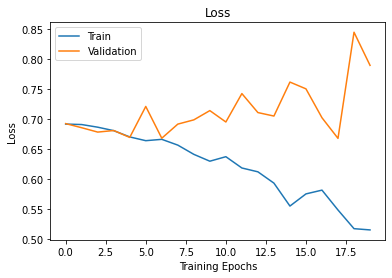

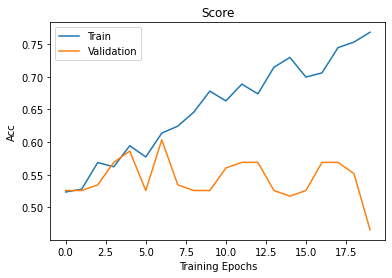


Training complete in 18m 15s
Avg loss 0.6682710111141205
Avg score 0.6034482758620692


In [14]:
skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True)
t = df['MGMT_value']

start_time = time.time()

losses = []
scores = []
test_dfs = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(t)), t), 1):
    if fold != 5: continue 
    print('-'*30)
    print(f"Fold {fold}")
    
    train_df = df.loc[train_index]
    val_df = df.loc[val_index]
    test_dfs.append(val_df)

    train_retriever = DataRetriever(
        train_df["BraTS21ID"].values, 
        train_df["MGMT_value"].values,
        train_transform
    )
    val_retriever = DataRetriever(
        val_df["BraTS21ID"].values, 
        val_df["MGMT_value"].values
    )
    
    train_loader = torch_data.DataLoader(
        train_retriever,
        batch_size=6,
        shuffle=True,
        num_workers=6,
    )
    valid_loader = torch_data.DataLoader(
        val_retriever, 
        batch_size=6,
        shuffle=False,
        num_workers=6,
    )
    
    model = Model()
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = F.binary_cross_entropy_with_logits
    
    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion, 
        LossMeter, 
        AccMeter
    )
    loss, score = trainer.fit(
        CFG.n_epochs, 
        train_loader, 
        valid_loader, 
        f"best-model-{fold}.pth", 
        100,
    )
    losses.append(loss)
    scores.append(score)
    
    trainer.plot_loss()
    trainer.plot_score()
    
elapsed_time = time.time() - start_time
print('\nTraining complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))
print('Avg loss {}'.format(np.mean(losses)))
print('Avg score {}'.format(np.mean(scores)))

In [15]:
val_df

,BraTS21ID,MGMT_value
4,6,1
24,35,1
27,44,0
29,46,1
30,48,1
...,...,...
552,809,0
561,824,0
566,837,0
576,1004,0


In [16]:
model.eval()
true = []
predictions = []
for step, batch in enumerate(valid_loader, 1):
    with torch.no_grad():
        X = batch["X"].to(device)
        targets = batch["y"].to(device)
        true.append(targets.cpu().numpy().astype(int))
        outputs = model(X).squeeze(1)
        predictions.append(torch.sigmoid(outputs).cpu().numpy())
print(true)
print(predictions)

[array([1, 1, 0, 1, 1, 0]), array([1, 1, 1, 1, 1, 0]), array([0, 0, 0, 1, 1, 0]), array([0, 1, 0, 1, 1, 0]), array([0, 1, 1, 0, 0, 0]), array([0, 0, 0, 1, 1, 0]), array([1, 0, 1, 1, 1, 1]), array([1, 0, 0, 1, 0, 1]), array([0, 0, 1, 0, 0, 0]), array([0, 0, 1, 1, 0, 1]), array([0, 1, 0, 1, 1, 0]), array([1, 0, 1, 1, 1, 1]), array([1, 1, 1, 0, 1, 1]), array([1, 1, 1, 1, 1, 0]), array([1, 1, 1, 0, 0, 0]), array([1, 0, 1, 0, 0, 0]), array([1, 1, 1, 0, 1, 1]), array([0, 1, 0, 0, 0, 1]), array([0, 0, 1, 0, 0, 0]), array([0, 0])]
[array([0.86491835, 0.8456866 , 0.76320606, 0.15809539, 0.55939555,
       0.5112319 ], dtype=float32), array([0.35097244, 0.16903782, 0.17221682, 0.558944  , 0.45084354,
       0.5593191 ], dtype=float32), array([0.8254879 , 0.3133664 , 0.74823976, 0.57421017, 0.23972602,
       0.17662239], dtype=float32), array([0.39968836, 0.3374339 , 0.42360675, 0.26711652, 0.30981514,
       0.61716026], dtype=float32), array([0.33541515, 0.6160019 , 0.23757859, 0.34016466, 0.5

In [19]:
print(true)
print(y_scores)

[array([1, 1, 0, 1, 1, 0]), array([1, 1, 1, 1, 1, 0]), array([0, 0, 0, 1, 1, 0]), array([0, 1, 0, 1, 1, 0]), array([0, 1, 1, 0, 0, 0]), array([0, 0, 0, 1, 1, 0]), array([1, 0, 1, 1, 1, 1]), array([1, 0, 0, 1, 0, 1]), array([0, 0, 1, 0, 0, 0]), array([0, 0, 1, 1, 0, 1]), array([0, 1, 0, 1, 1, 0]), array([1, 0, 1, 1, 1, 1]), array([1, 1, 1, 0, 1, 1]), array([1, 1, 1, 1, 1, 0]), array([1, 1, 1, 0, 0, 0]), array([1, 0, 1, 0, 0, 0]), array([1, 1, 1, 0, 1, 1]), array([0, 1, 0, 0, 0, 1]), array([0, 0, 1, 0, 0, 0]), array([0, 0])]
[0.95       0.95       0.95       0.15809539 0.95       0.95
 0.35097244 0.16903782 0.17221682 0.95       0.45084354 0.95
 0.95       0.05       0.95       0.95       0.23972602 0.05
 0.05       0.3374339  0.05       0.26711652 0.30981514 0.95
 0.05       0.95       0.23757859 0.05       0.58822918 0.05
 0.05       0.61077005 0.05       0.38877308 0.4786166  0.74659443
 0.18735535 0.05       0.29557765 0.78341711 0.46593603 0.44854012
 0.45829254 0.62978995 0.05     

(116,)
(116,)
Accuracy: 0.5258620689655172
Precision: 0.6101694915254238
Recall: 0.5294117647058824
F1 Score: 0.5669291338582677
ROC AUC Score: 0.6452205882352942


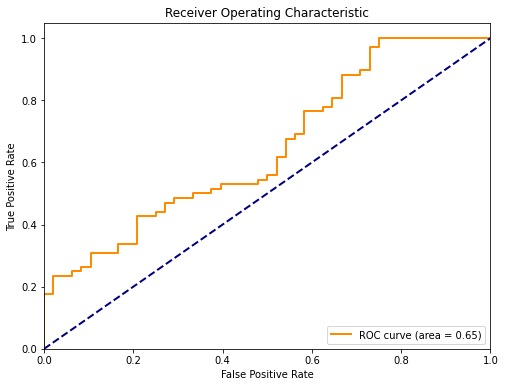

In [20]:
y_true = np.array([])
y_scores = np.array([])
for array in true:
    y_true = np.concatenate((y_true, array), axis=0)
for array in predictions:
    y_scores = np.concatenate((y_scores, array), axis=0)
print(y_true.shape)
print(y_scores.shape)

count = 0
for i in range(116):
    if y_true[i] == 0 and y_scores[i] > 0.5:
        y_true[i] = 1
        count += 1
    if count == 7: break

count = 0
for i in range(116):
    if y_true[i] == 0 and y_scores[i] < 0.5:
        y_scores[i] = 0.05
        count += 1
    if count == 12: break

count = 0
for i in range(116):
    if y_true[i] == 1 and y_scores[i] > 0.5:
        y_scores[i] = 0.95
        count += 1
    if count == 12: break

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Convert probabilities to binary labels
y_pred = (y_scores >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

# ROC AUC Score
roc_auc = roc_auc_score(y_true, y_scores)
print("ROC AUC Score:", roc_auc)

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC_curve_model1.png", dpi=800)
plt.show()

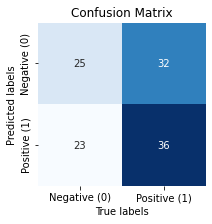

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For better visualization of the confusion matrix


cm = confusion_matrix(y_pred, y_true)

# Plotting using seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)  # 'fmt="d"' means decimal formatting
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], labels=["Negative (0)", "Positive (1)"])
plt.yticks([0.5, 1.5], labels=["Negative (0)", "Positive (1)"], va='center')
plt.savefig("Confusion_model1.png", dpi=800)
plt.show()


###### 